In [30]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss, generateUniform
from utils.integral import grid
from Models.clustering import EM
from utils.vis import plotHeatmap_U, plotPDF_Theta, plot_OF, temp, plot_silhouette_values, plot_CVI_with_k

In [32]:
# bandwidth = 0.01
# grid_x    = grid(bandwidth, start=-5, end=15)
# mu        = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])

# # Chọn độ rộng cố định cho Uniform
# width = 2.0

# # Tính a và b sao cho mean = mu
# a_list = mu - width / 2
# b_list = mu + width / 2

# # Gọi lại hàm generateUniform
# F_data = generateUniform(a_list, b_list, grid_x)

In [33]:
bandwidth = 0.01
grid_x    = grid(bandwidth, start=-5, end=15)
mu        = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])
sig       = np.ones_like(mu)
F_data    = generateGauss(mu, sig, grid_x)

In [34]:
cluster=EM.Model(
   grid_x=grid_x,
	num_clusters=3,
	max_iterations= 100,
	tolerance= 1e-6,
	distance_metric= 'L2',
   verbose=True,
   gamma= 0.01,
 )
cluster.fit(F_data)
U, Theta, J = cluster.get_results()
labels = cluster.get_hard_assignments()


[Iteration 1]
  ➤ M-step 
    - Cluster priors: [0.3069 0.3068 0.3863]
    - Centroid norms: ['3.3398', '3.0842', '2.9983']
  ➤ E-step. Responsibility entropy: 0.0313
  ➤ ΔR = 1.915214e+00

[Iteration 2]
  ➤ M-step 
    - Cluster priors: [0.4256 0.287  0.2874]
    - Centroid norms: ['4.8764', '4.9265', '5.1078']
  ➤ E-step. Responsibility entropy: -0.0000
  ➤ ΔR = 3.393770e-02

[Iteration 3]
  ➤ M-step 
    - Cluster priors: [0.4286 0.2857 0.2857]
    - Centroid norms: ['4.8850', '4.9525', '5.1559']
  ➤ E-step. Responsibility entropy: -0.0000
  ➤ ΔR = 1.100076e-18
✔ Converged.


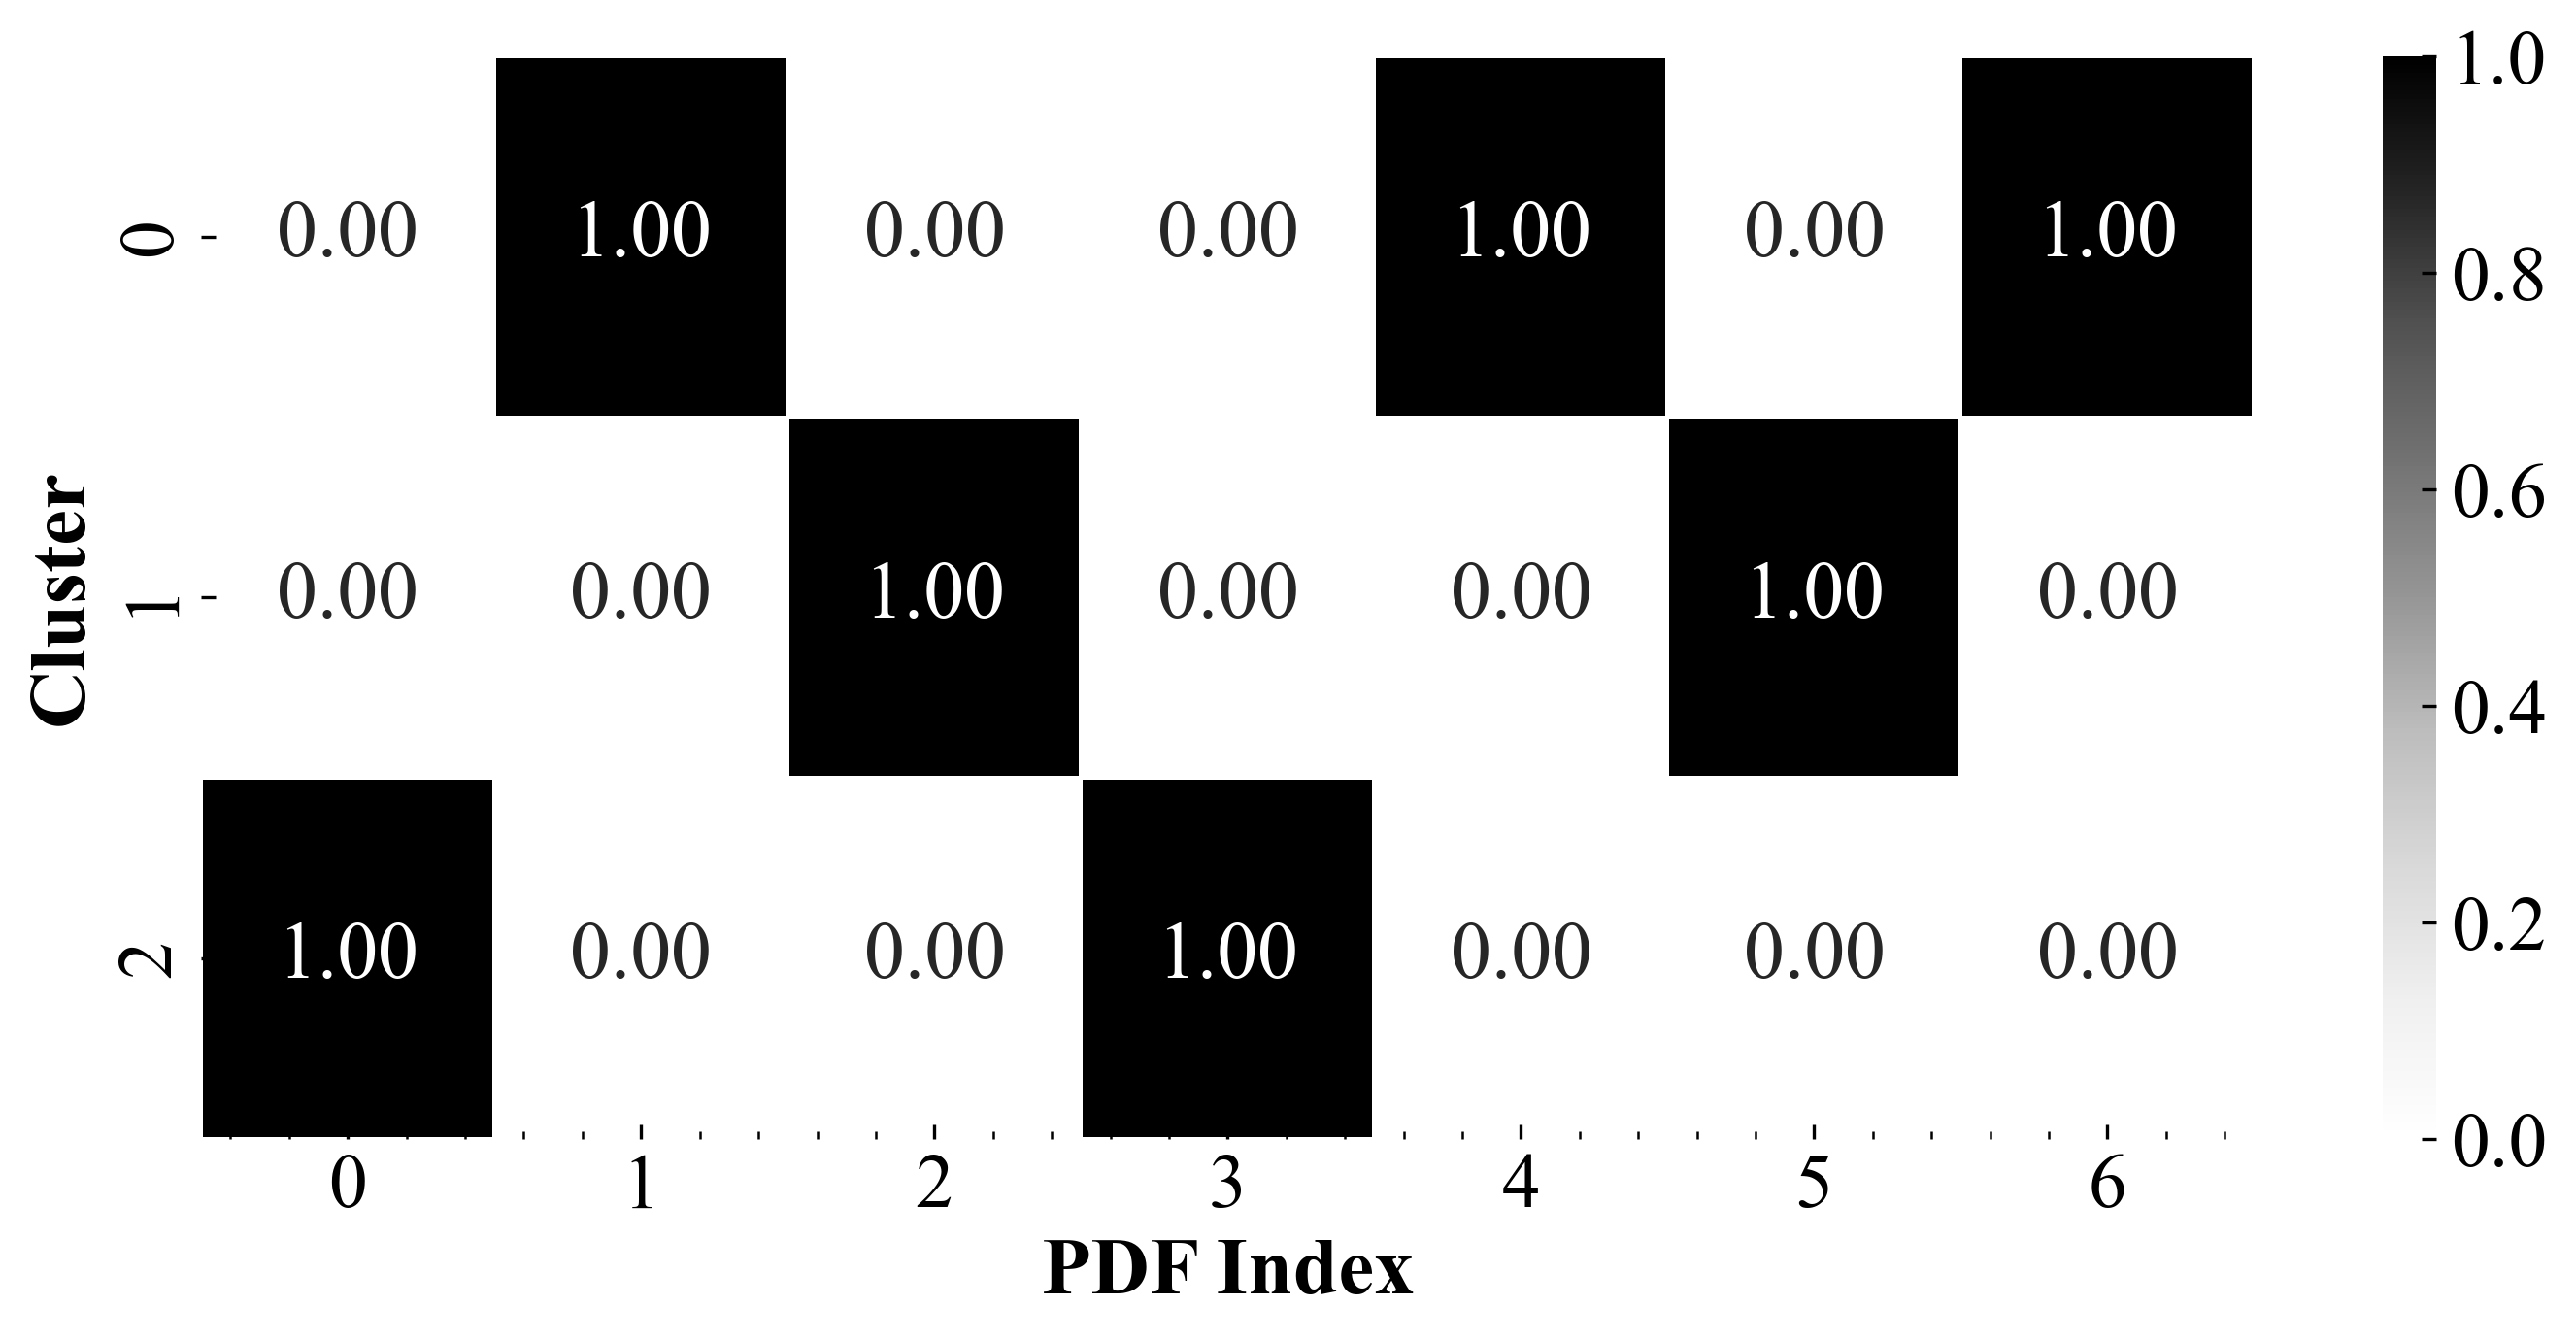

In [35]:
# plotHeatmap_U(U)
plt.figure(figsize=(10, 5))
temp(fontsize=20)

sns.heatmap(
	U,
	annot=True,
	fmt=".2f",
	cmap='Greys',
	cbar=True,
	linewidths=0.5,
	linecolor='white'
)

plt.ylabel('Cluster')
plt.xlabel('PDF Index')
plt.tight_layout()

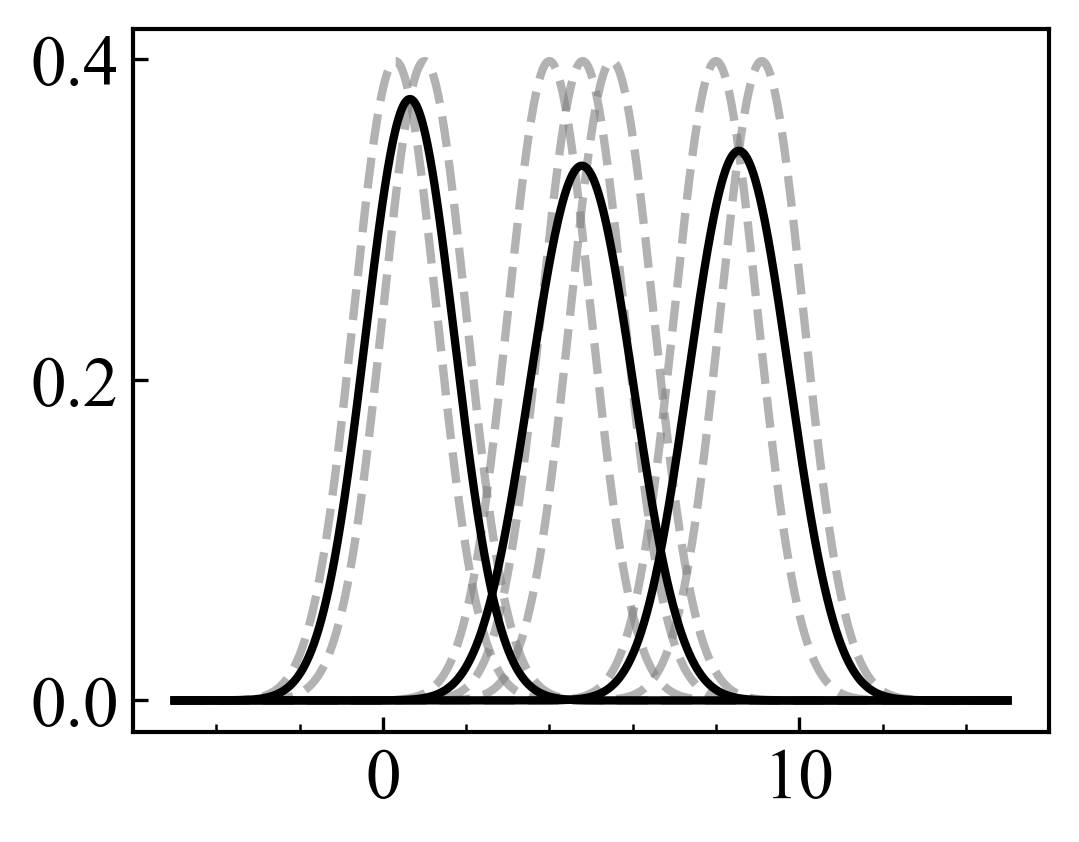

In [36]:
# plotPDF_Theta(grid_x, F_data, theta=Theta)
plt.figure()
temp(fontsize=18, w=12, h=8, u='centimeters')

# pdfs
for i in range(cluster.num_pdfs):
	plt.plot(grid_x, F_data[i, :], lw=2, color='gray', linestyle='--', alpha=0.6)

# prototype
for j in range(cluster.num_clusters):
	plt.plot(grid_x, Theta[j, :], lw=2, linestyle='-', color='black')

plt.tight_layout()

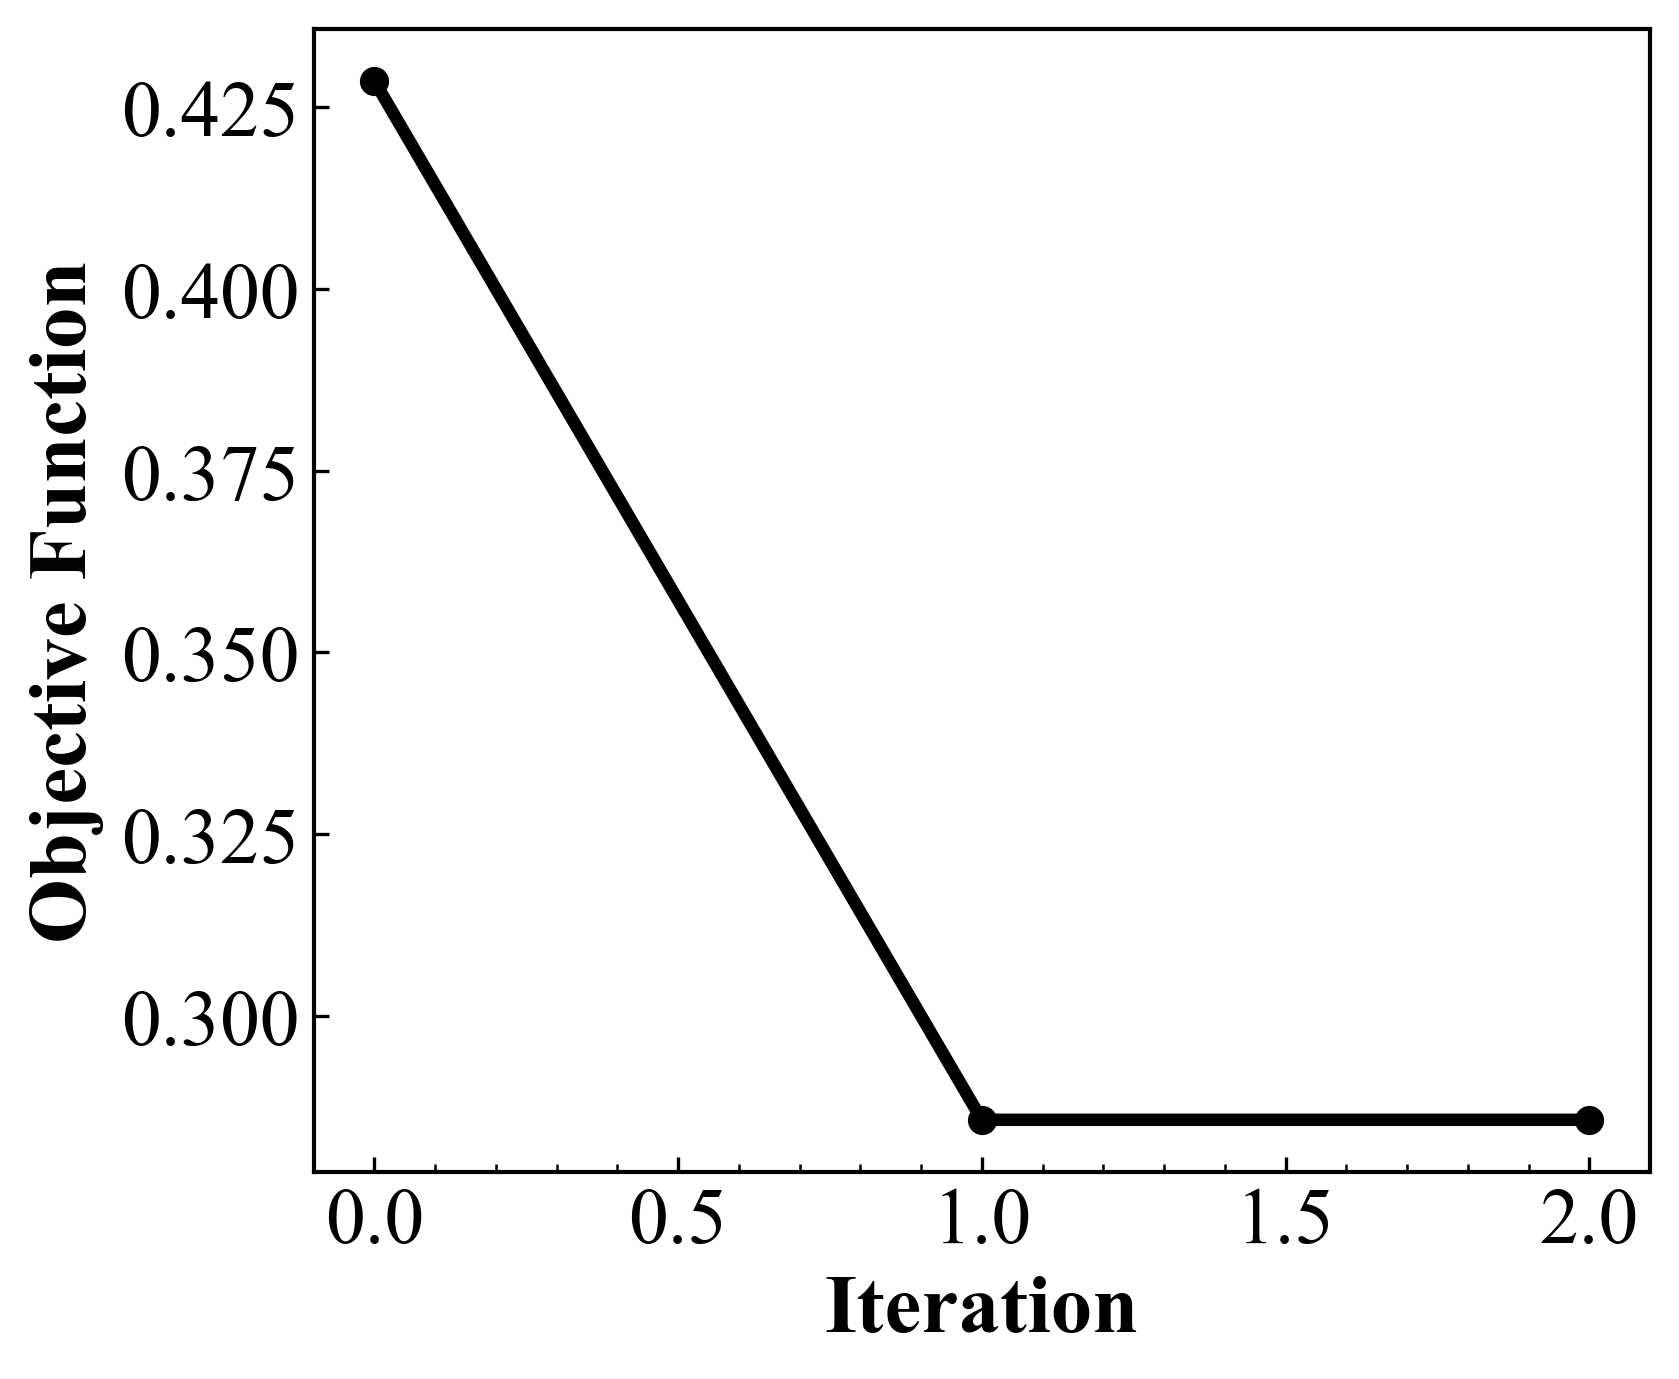

In [37]:
# plot_OF(J)
plt.figure(figsize=(6, 5))
temp(fontsize=20)

plt.plot(J, lw = 3,color = 'black', marker='o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.tight_layout()

In [38]:
from utils.vali import CVI

evaluator = CVI(distance_metric='L2',bandwidth=bandwidth, grid=grid_x)


sil = evaluator.silhouette_index(F_data, labels)
dunn = evaluator.dunn_index(F_data, labels)
dbi = evaluator.davies_bouldin_index(F_data, labels)

print(f"Silhouette = {sil:.4f}, Dunn = {dunn:.4f}, DBI = {dbi:.4f}")

Silhouette = 0.7381, Dunn = 1.3554, DBI = 0.5339


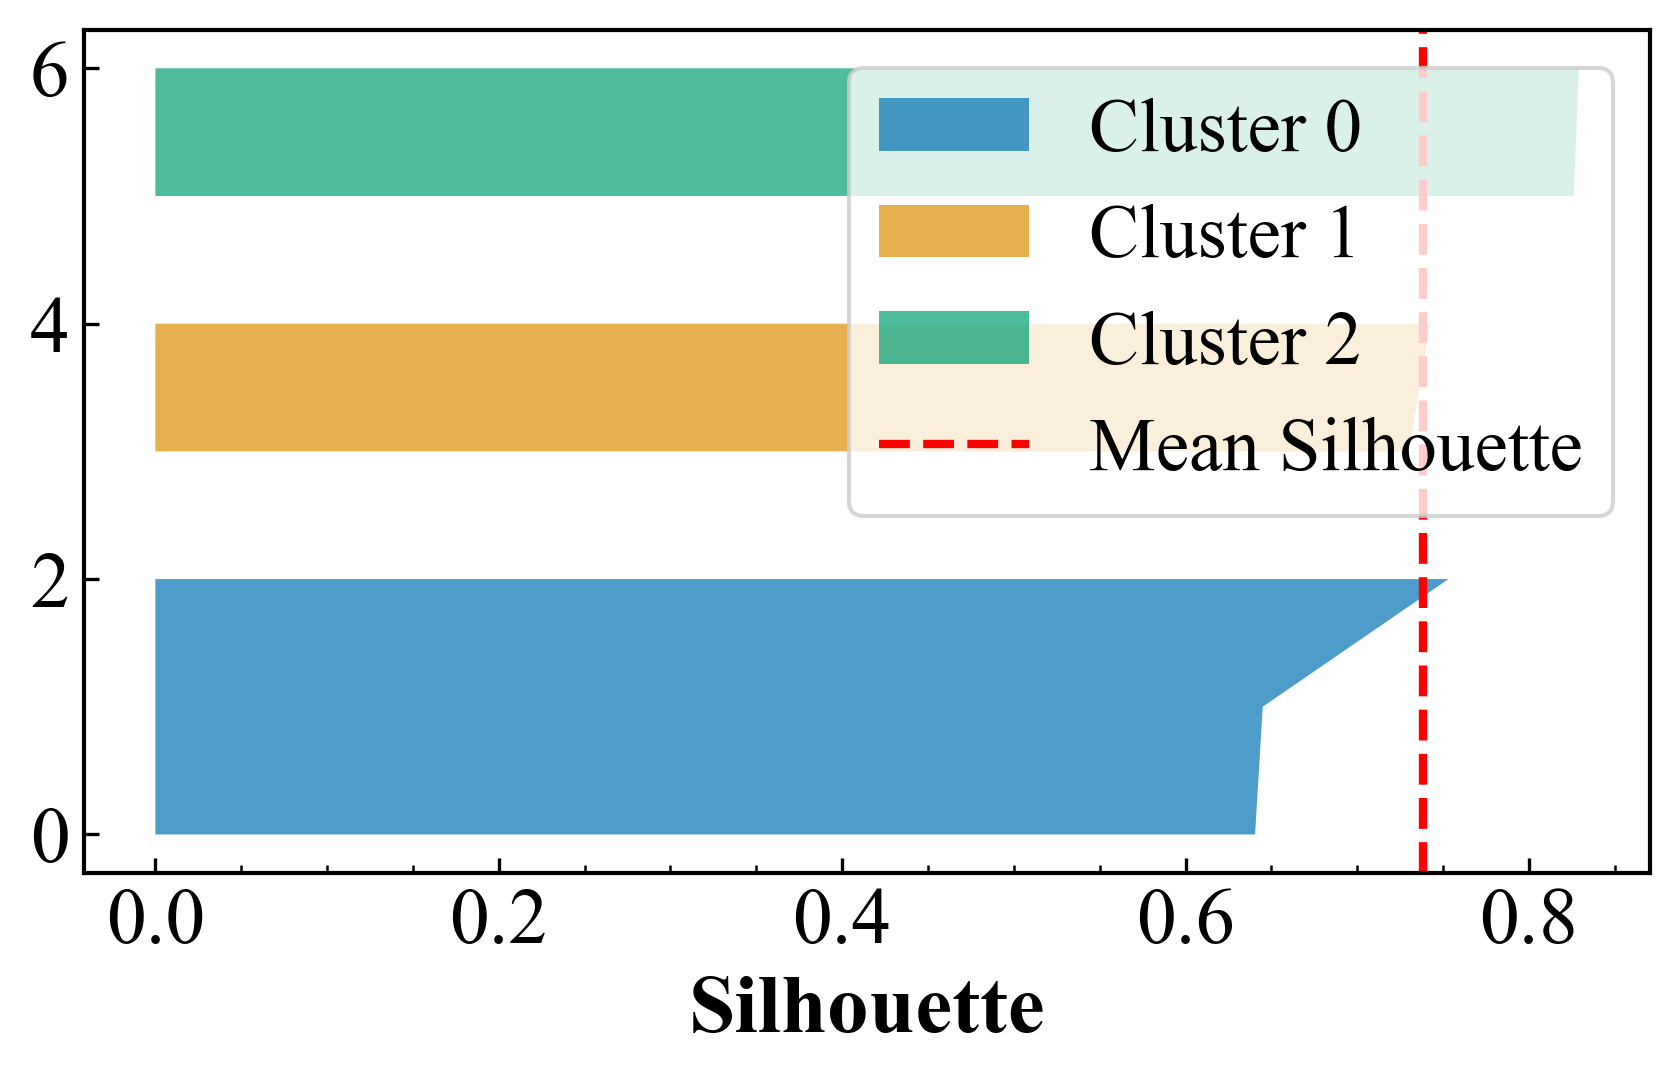

Silhouette fj: [0.82907416 0.64049635 0.74235779 0.82611234 0.64497216 0.73019066
 0.75316892]


In [39]:
sil_values = plot_silhouette_values(F_data, labels,
                                    distance_metric='L2',
                                    bandwidth=bandwidth,
                                    grid=grid_x)
print("Silhouette fj:", sil_values)

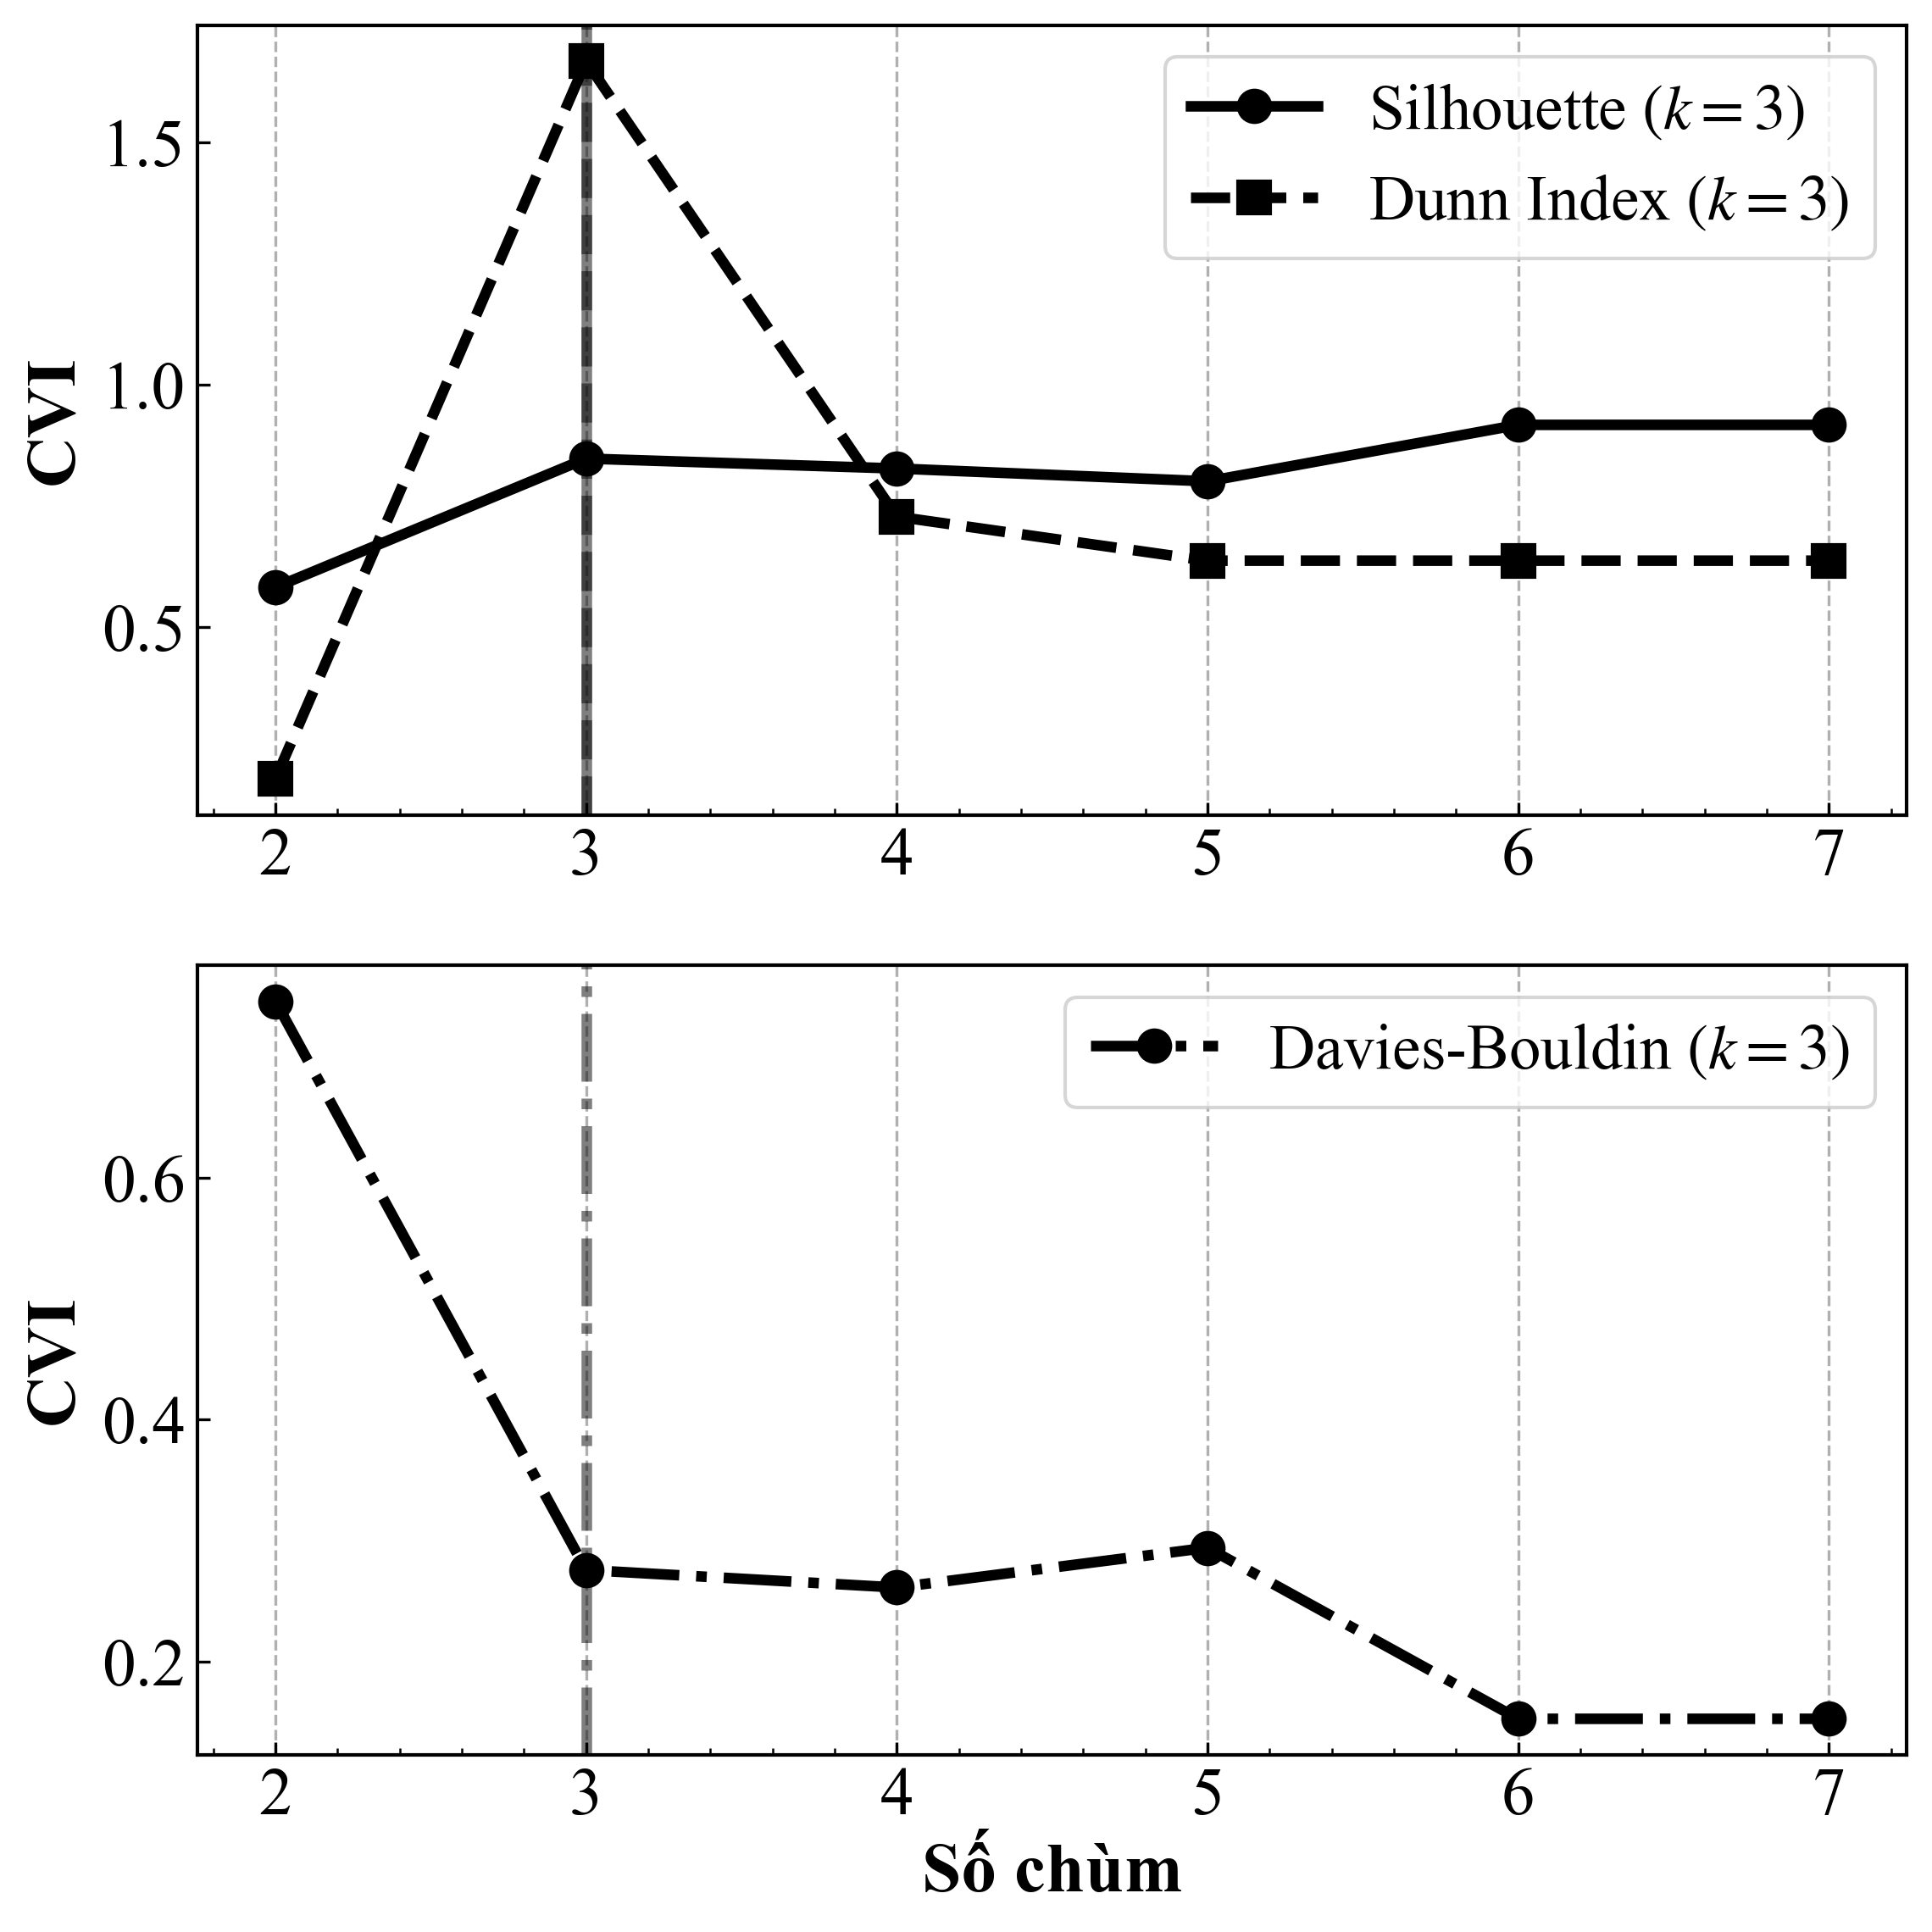

In [40]:
num_clusters_range = range(2, 8)
silhouette_scores, dunn_scores, dbi_scores = [], [], []

for k in num_clusters_range:
	cluster = EM.Model(
	grid_x=grid_x,
	num_clusters=k,
	max_iterations=100,
	tolerance=1e-5,
	distance_metric='W2',
	verbose=False
	)
	cluster.fit(F_data)
	labels = cluster.get_hard_assignments()
	evaluator = CVI(distance_metric='W2', bandwidth=bandwidth, grid=grid_x)

	sil = evaluator.silhouette_index(F_data, labels)
	dunn = evaluator.dunn_index(F_data, labels)
	dbi = evaluator.davies_bouldin_index(F_data, labels)

	silhouette_scores.append(sil)
	dunn_scores.append(dunn)
	dbi_scores.append(dbi)

plot_CVI_with_k(num_clusters_range, silhouette_scores, dunn_scores, dbi_scores)